In [2]:
from semantic_router.encoders import OpenAIEncoder
from pinecone import Pinecone, ServerlessSpec
import os
from langchain_core.tools import tool
import requests
import re
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from serpapi import GoogleSearch
import os
import requests
from xml.etree import ElementTree
from urllib.parse import quote_plus
from langchain_openai import ChatOpenAI
from typing import List, Dict
from functools import wraps
from datetime import datetime
# RUn the ~/Documents/export_api_keys.sh before running this

In [3]:
%%bash
/Users/saisuryamadhav/Documents/export_api_keys.sh

Environment variables set successfully


In [4]:
encoder = OpenAIEncoder(name='text-embedding-3-small')
llm = ChatOpenAI(
    model="gpt-4o",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)
pc = Pinecone(api_key="9c4a6318-3201-4abe-b850-ecc5b87851d0")
spec = ServerlessSpec(cloud="aws", region="us-east-1")
index = pc.Index("cfa-research")
index.describe_index_stats()


{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'investment_research': {'vector_count': 2382}},
 'total_vector_count': 2382}

In [5]:
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

def log_decorator(func):
    def wrapper(*args, **kwargs):
        logging.info(f"Executing {func.__name__} with args: {args}, kwargs: {kwargs}")
        result = func(*args, **kwargs)
        logging.info(f"Finished {func.__name__} with result: {result}")
        return result
    return wrapper

In [6]:
from langchain.agents import AgentExecutor, create_react_agent, load_tools


@tool("fetch_arxiv")
def fetch_arxiv(query: str) -> List[Dict[str, any]]:
    """Fetches academic papers related to the query from arXiv.
    Returns a list of relevant academic papers with titles, authors, and abstracts.
    
    Args:
        query (str): Search query for papers
        
    Returns:
        List[Dict]: List of papers with title, authors, abstract, and url
    """
    try:
        # Prepare URL with sanitized query
        sanitized_query = quote_plus(query.strip())
        url = f"http://export.arxiv.org/api/query?search_query=all:{sanitized_query}&start=0&max_results=5"
        
        # Make request
        response = requests.get(url, timeout=10)
        response.raise_for_status()

        # Parse XML
        root = ElementTree.fromstring(response.content)
        formatted_papers = []

        # Process each entry
        for entry in root.findall('{http://www.w3.org/2005/Atom}entry'):
            try:
                # Extract paper details
                title = entry.find('{http://www.w3.org/2005/Atom}title').text.strip()
                abstract = entry.find('{http://www.w3.org/2005/Atom}summary').text.strip()
                authors = [author.find('{http://www.w3.org/2005/Atom}name').text.strip()
                          for author in entry.findall('{http://www.w3.org/2005/Atom}author')]
                
                # Get paper URL
                url = next(
                    (link.get('href') for link in entry.findall('{http://www.w3.org/2005/Atom}link') 
                     if link.get('rel') == 'alternate'),
                    None
                )
                
                formatted_papers.append({
                    "title": title,
                    "authors": authors,
                    "abstract": abstract,
                    "url": url
                })
            except AttributeError as e:
                print(f"[{datetime.now()}] Skipping paper due to missing data: {str(e)}")
                continue
        print(f"[{datetime.now()}] Fetched {len(formatted_papers)} papers from arXiv")

        return formatted_papers

    except Exception as e:
        print(f"[{datetime.now()}] Error fetching papers: {str(e)}")
        return []
    


@tool("search_google")
def search_google(query: str):
    """Searches Google for articles and web pages related to the query.
    Returns a list of relevant search results with titles and snippets."""
    search = GoogleSearch({
        "q": query,
        "api_key": "962f28dc21253170516789239227c4ad83012fd35c888f45d5d502669ac95509",
        "num": 5  # Number of results to return
    })
    results = search.get_dict()
    
    formatted_results = []
    for result in results.get("organic_results", []):
        formatted_results.append({
            "title": result.get("title"),
            "snippet": result.get("snippet"),
            "link": result.get("link")
        })
    print(f"[{datetime.now()}] Fetched {len(formatted_results)} search results from Google")
    return formatted_results


@tool("search_scholar")
def search_scholar(query: str):
    """Searches Google Scholar for academic papers related to the query.
    Returns a list of relevant academic papers with titles, authors, and abstracts."""
    search = GoogleSearch({
        "q": query,
        "api_key": "962f28dc21253170516789239227c4ad83012fd35c888f45d5d502669ac95509",
        "engine": "google_scholar",
        "num": 5  # Number of results to return
    })
    
    results = search.get_dict()
    print(len(results))
    formatted_results = []
    for result in results.get("organic_results", []):
        formatted_results.append({
            "title": result.get("title"),
            "authors": result.get("authors", ""),
            "publication": result.get("publication_info", {}).get("summary", ""),
            "snippet": result.get("snippet"),
            "link": result.get("link"),
            "citations": result.get("inline_links", {}).get("cited_by", {}).get("total", 0)
        })
    print(f"[{datetime.now()}] Fetched {len(formatted_results)} search results from Google Scholar")
    return formatted_results

In [7]:
import operator
from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated

class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [8]:
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    print(f"""
    introduction: {introduction}
    research_steps: {research_steps}
    main_body: {main_body}
    conclusion: {conclusion}
    sources: {sources}
    """)
    return ""

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

In [10]:
tools = [
    fetch_arxiv,
    search_google,
    search_scholar,
    final_answer
]
tools_str_to_func = {
    "fetch_arxiv": fetch_arxiv,
    "search_google": search_google,
    "search_scholar": search_scholar,
    "final_answer": final_answer
}

In [11]:
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
            print(f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}")
    return "\n---\n".join(research_steps)


In [12]:
oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

In [13]:
oracle.invoke(
    {
        "input": "What is the best way to reduce carbon emissions?",
        "chat_history": [],
        "intermediate_steps": []
    }
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_y8bBGOAVztZWxEeC7qNOIVH7', 'function': {'arguments': '{"query": "best ways to reduce carbon emissions"}', 'name': 'fetch_arxiv'}, 'type': 'function'}, {'id': 'call_ziApfxSRij9XzLt2q3auyLuF', 'function': {'arguments': '{"query": "best ways to reduce carbon emissions"}', 'name': 'search_google'}, 'type': 'function'}, {'id': 'call_SgV58NBXCzqFhJshyCrxOjb7', 'function': {'arguments': '{"query": "best ways to reduce carbon emissions"}', 'name': 'search_scholar'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 531, 'total_tokens': 607, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'tool_calls', 'logprobs': No

In [14]:
def run_oracle(state: list):
    print("------RUN ORACLE------")
    # TODO: Check why we only read the first tool
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    print("------ORACLE AGENT CALL------")
    print(f"{tool_name}.invoke(input={tool_args})")
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        print("Router received request to return tool ")
        print(state["intermediate_steps"][-1])
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"
    
def run_tool(state: list):
    # use this as helper function so we repeat less code    
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tools_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

In [15]:
graph = StateGraph(AgentState)
graph.add_node("oracle", run_oracle)
graph.add_node("fetch_arxiv", run_tool)
graph.add_node("search_google", run_tool)
graph.add_node("search_scholar", run_tool)
graph.add_node("final_answer", run_tool)
graph.set_entry_point("oracle")
graph.add_conditional_edges(source="oracle", path=router)
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")
graph.add_edge("final_answer", END)
runnable = graph.compile()  

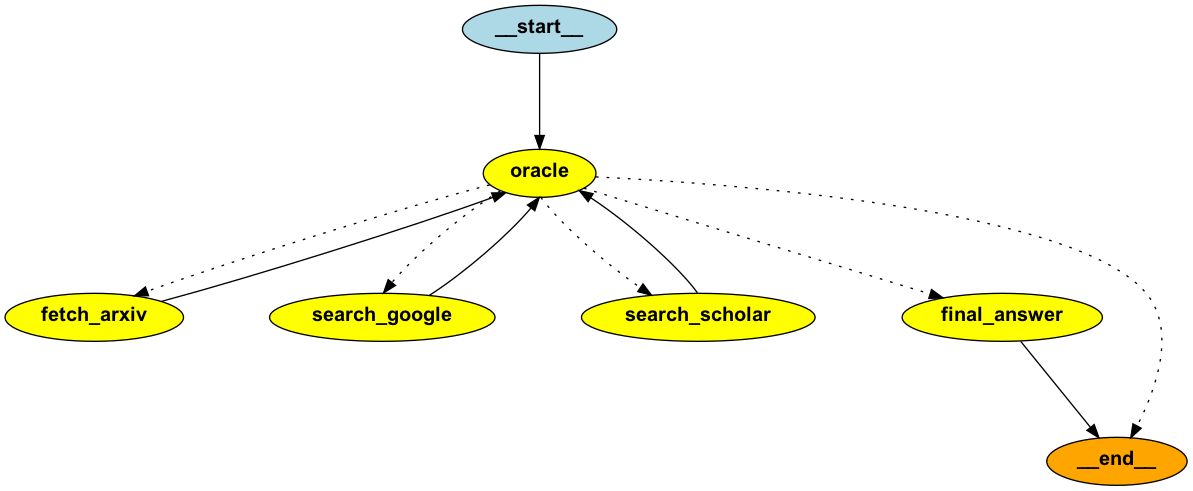

In [16]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [17]:
out = runnable.invoke({
    "input": "The Economics of Private Equity: A Critical Review",
    "chat_history": [],
})

------RUN ORACLE------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


------ORACLE AGENT CALL------
fetch_arxiv.invoke(input={'query': 'Economics of Private Equity: A Critical Review'})
Router received request to return tool 
tool='fetch_arxiv' tool_input={'query': 'Economics of Private Equity: A Critical Review'} log='TBD'
fetch_arxiv.invoke(input={'query': 'Economics of Private Equity: A Critical Review'})
[2024-11-14 22:31:14.882344] Fetched 5 papers from arXiv
------RUN ORACLE------
Tool: fetch_arxiv, input: {'query': 'Economics of Private Equity: A Critical Review'}
Output: [{'title': 'Critical Infrastructure Security: Penetration Testing and Exploit\n  Development Perspectives', 'authors': ['Papa Kobina Orleans-Bosomtwe'], 'abstract': 'Critical infrastructure refers to essential physical and cyber systems vital\nto the functioning and stability of societies and economies. These systems\ninclude key sectors such as healthcare, energy, and water supply, which are\ncrucial for societal and economic stability and are increasingly becoming prime\ntarget

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


------ORACLE AGENT CALL------
search_google.invoke(input={'query': 'Economics of Private Equity: A Critical Review'})
Router received request to return tool 
tool='search_google' tool_input={'query': 'Economics of Private Equity: A Critical Review'} log='TBD'
search_google.invoke(input={'query': 'Economics of Private Equity: A Critical Review'})
[2024-11-14 22:31:18.075481] Fetched 5 search results from Google
------RUN ORACLE------
Tool: fetch_arxiv, input: {'query': 'Economics of Private Equity: A Critical Review'}
Output: [{'title': 'Critical Infrastructure Security: Penetration Testing and Exploit\n  Development Perspectives', 'authors': ['Papa Kobina Orleans-Bosomtwe'], 'abstract': 'Critical infrastructure refers to essential physical and cyber systems vital\nto the functioning and stability of societies and economies. These systems\ninclude key sectors such as healthcare, energy, and water supply, which are\ncrucial for societal and economic stability and are increasingly becomin

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


------ORACLE AGENT CALL------
search_scholar.invoke(input={'query': 'Economics of Private Equity: A Critical Review'})
Router received request to return tool 
tool='search_scholar' tool_input={'query': 'Economics of Private Equity: A Critical Review'} log='TBD'
search_scholar.invoke(input={'query': 'Economics of Private Equity: A Critical Review'})
6
[2024-11-14 22:31:20.109590] Fetched 5 search results from Google Scholar
------RUN ORACLE------
Tool: fetch_arxiv, input: {'query': 'Economics of Private Equity: A Critical Review'}
Output: [{'title': 'Critical Infrastructure Security: Penetration Testing and Exploit\n  Development Perspectives', 'authors': ['Papa Kobina Orleans-Bosomtwe'], 'abstract': 'Critical infrastructure refers to essential physical and cyber systems vital\nto the functioning and stability of societies and economies. These systems\ninclude key sectors such as healthcare, energy, and water supply, which are\ncrucial for societal and economic stability and are increas

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


------ORACLE AGENT CALL------
final_answer.invoke(input={'introduction': 'Private equity has become a significant component of the global financial landscape, influencing various sectors and economies. This report aims to critically review the economics of private equity, focusing on its performance, value creation, and broader economic impacts.', 'research_steps': '- Conducted a search on arXiv for academic papers related to the economics of private equity.\n- Searched Google for articles and web pages discussing the critical review of private equity economics.\n- Utilized Google Scholar to find academic papers and reviews on the economic impact and theories of private equity.', 'main_body': 'Private equity (PE) has grown into a multi-trillion dollar asset class over the past few decades, playing a pivotal role in corporate finance and economic development. The primary focus of private equity is to invest in companies, often through buyouts, with the aim of improving their performance

In [18]:
def build_report(output: dict):
    output = output.get("intermediate_steps")[-1].tool_input
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

In [47]:
build_report(out)

"\nINTRODUCTION\n------------\nPrivate equity has become a significant component of the global financial landscape, influencing various sectors and economies. This research report delves into the economics of private equity, providing a critical review of its impact, performance, and the broader economic implications.\n\nRESEARCH STEPS\n--------------\n- Conducted a search on arXiv for academic papers related to the economics of private equity.\n- Searched Google for articles and web pages discussing the critical review of private equity economics.\n- Utilized Google Scholar to find academic papers and reviews on the economic impact of private equity.\n\nREPORT\n------\nPrivate equity, as an asset class, has grown substantially over the past few decades, reaching a valuation of approximately $3 trillion. This growth has sparked considerable academic interest, leading to numerous studies examining its economic impact. The literature reveals that private equity can significantly influenc

In [48]:
out

{'input': 'The Economics of Private Equity: A Critical Review',
 'chat_history': [],
 'intermediate_steps': [AgentAction(tool='fetch_arxiv', tool_input={'query': 'Economics of Private Equity: A Critical Review'}, log='TBD'),
  AgentAction(tool='fetch_arxiv', tool_input={'query': 'Economics of Private Equity: A Critical Review'}, log='[{\'title\': \'Critical Infrastructure Security: Penetration Testing and Exploit\\n  Development Perspectives\', \'authors\': [\'Papa Kobina Orleans-Bosomtwe\'], \'abstract\': \'Critical infrastructure refers to essential physical and cyber systems vital\\nto the functioning and stability of societies and economies. These systems\\ninclude key sectors such as healthcare, energy, and water supply, which are\\ncrucial for societal and economic stability and are increasingly becoming prime\\ntargets for malicious actors, including state-sponsored hackers, seeking to\\ndisrupt national security and economic stability. This paper reviews literature\\non critica